# Measurement

In [2]:
import time
from datetime import datetime

import numpy as np
from sciopy import (
    SoftwareReset_usb_hs,
    SystemMessageCallback_usb_hs,
    available_serial_ports,
    connect_COM_port,
    connect_COM_port_usb_hs,
    reshape_full_message_in_bursts,
    set_measurement_config_usb_hs,
    split_bursts_in_frames,
)

from sciopy.sciopy_dataclasses import ScioSpecMeasurementSetup
from tqdm import tqdm

from src.classes import (
    BallAnomaly,
    Ender5Stat,
    HitBox,
    MeasurementInformation,
    TankProperties32x2,
)
from src.ender5 import (
    init_ender5,
    move_ender_to_coordinate,
    move_to_absolute_x_y_z,
    read_temperature,
    x_y_z_home,
)
from src.functions import (
    compute_hitbox,
    create_meas_coordinates,
    create_measurement_directory,
    create_mesh,
    empty_tank_measurement,
    print_coordinates_props,
    rename_savedir,
    save_parameters_to_json_file,
    set_perm,
)
from src.sciospec import sciospec_measurement
from src.visualization import plot_meas_coords, plot_meas_coords_wball, plot_mesh

## Define the parameters

In [17]:
# init tank
tank = TankProperties32x2()
# init ball
ball = BallAnomaly(x=0, y=0, z=0, d=10, perm=10, material="acryl")
# init hitbox
hitbox = compute_hitbox(tank, ball, safety_tolerance=10.0)
# set min and max z-pos to ball.d/2
hitbox.z_min = tank.E_zr1 - ball.d / 4
hitbox.z_max = tank.E_zr2 + ball.d / 4
# set sciospec measurement properties
ssms = ScioSpecMeasurementSetup(
    burst_count=5,  # The number of measurements to be performed.
    total_meas_num=10,  # Repetitions of burst count
    n_el=64,  # Set 16, 32, 48 or 64 and do not forget to change the channel_group.
    channel_group=[
        1,
        2,
        3,
        4,
    ],  # Use [1] for n_el=16, [1,2] for n_el=32, [1,2,3] for n_el=48, and [1,2,3,4] for n_el=64
    exc_freq=125_000,  # 10,000Hz = 10kHz
    framerate=5,  # Measurements per second
    amplitude=0.01,  # 0.01A = 10mA (maximum)
    inj_skip=8,  # injection electrode skip
    gain=1,
    adc_range=1,  # +/- 1V
    notes="test measurement",  # add measurement information
    configured=True,
)

print(tank)
print(ball)
print(hitbox)
print(ssms)

TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 140), E_zr1=50, E_zr2=100, n_el=64)
BallAnomaly(x=0, y=0, z=0, d=10, perm=10, material='acryl')
HitBox(r_min=0, r_max=82.0, x_min=-82.0, x_max=82.0, y_min=-82.0, y_max=82.0, z_min=47.5, z_max=102.5)
ScioSpecMeasurementSetup(burst_count=5, total_meas_num=10, n_el=64, channel_group=[1, 2, 3, 4], exc_freq=125000, framerate=5, amplitude=0.01, inj_skip=8, gain=1, adc_range=1, notes='test measurement', configured=True)


In [18]:
coordinates = create_meas_coordinates(hitbox, x_pts=20, y_pts=20, z_pts=15)
print_coordinates_props(coordinates)

HitBox(x_pts,y_pts,z_pts) leads to 4140 available points.
So 4140 points will be measured.
Properties of the computed coordinates
--------------------------------------
min:-73.37	max: 73.37
min:-73.37	max: 73.37
min:47.50	max: 102.50

shape (4140, 3)


In [19]:
coordinates = np.round(coordinates, 1)
coordinates

array([[-30.2, -73.4,  47.5],
       [-30.2, -73.4,  51.4],
       [-30.2, -73.4,  55.4],
       ...,
       [ 30.2,  73.4,  94.6],
       [ 30.2,  73.4,  98.6],
       [ 30.2,  73.4, 102.5]])

In [20]:
print("total number of .npz files:", coordinates.shape[0] * ssms.burst_count)

total number of .npz files: 20700


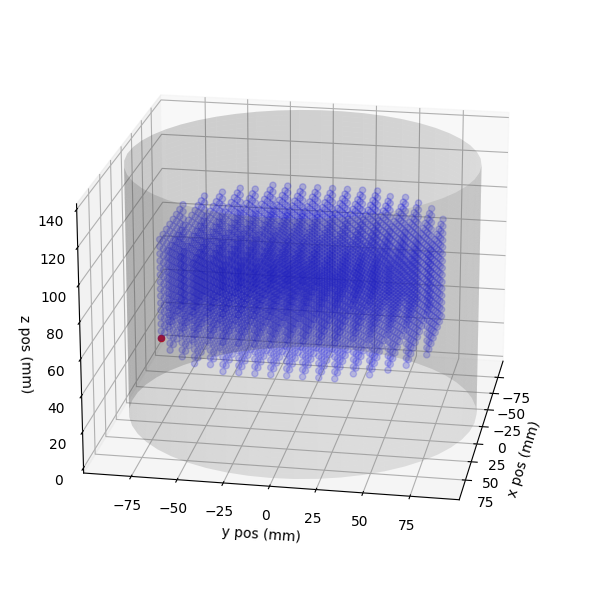

BallAnomaly(x=-30.2, y=-73.4, z=47.5, d=10, perm=10, material='acryl')


PyEIT3DMesh(x_nodes=array([0., 0., 0., ..., 0., 0., 0.]), y_nodes=array([-97., -97., -97., ...,  97.,  97.,  97.]), z_nodes=array([  0.        ,  10.76923077,  21.53846154, ..., 118.46153846,
       129.23076923, 140.        ]), perm_array=array([1., 1., 1., ..., 1., 1., 1.]), x_obj_pos=None, y_obj_pos=None, z_obj_pos=None, r_obj=None, material='acryl')

In [21]:
sel_coor_test = 0
plot_meas_coords(tank=tank, meas_coords=coordinates, p_select=sel_coor_test)

ball.x, ball.y, ball.z = coordinates[sel_coor_test]
print(ball)
# create an empty mesh
mesh_obj = create_mesh(tank)
set_perm(mesh_obj, anomaly=ball)
# plot mesh
# plot_mesh(mesh_obj, tank, azim=15)

In [22]:
# measurement information for documentation
today = datetime.now()
documentation = MeasurementInformation(
    saline=(9.01, "[ppt]"),
    saline_height=(134.0, "[mm]"),  # heigh without object
    temperature=(18.2, "[°C]"),
    timestamp=today.strftime("%d_%m_%Y_%Hh_%Mm"),
)

In [23]:
s_path, f_name = create_measurement_directory()
save_parameters_to_json_file(s_path, f_name, documentation, ssms, tank, ball, hitbox)

Created new measurement directory at: measurements/08_02_2024_08h_39m
Saved properties to: measurements/08_02_2024_08h_39m/data/


## Connect Devices

- Create 3D objects
- Init Ender 5
- Centering object depending on size
- Init Sciospec
- Send config to sciospec
- Start Measurement

In [24]:
COM_Ender = connect_COM_port(port="COM4", baudrate=115200)
COM_Sciospec = connect_COM_port_usb_hs()

Connection to COM4 is established.


In [25]:
enderstat = Ender5Stat(
    abs_x_pos=None,
    abs_y_pos=None,
    abs_z_pos=None,
    tank_architecture=TankProperties32x2(),
    motion_speed=180,
)

In [26]:
# init axis -> RUN ONLY IF NO OBJECT IS IN THE MOUNTING CONSTRUCTION
init_ender5(COM_Ender, enderstat)

## Set Sciospec Config

In [27]:
set_measurement_config_usb_hs(COM_Sciospec, ssms)

In [29]:
# Read out system callback
SystemMessageCallback_usb_hs(COM_Sciospec, prnt_msg=True)

No message inside the message buffer


## Measurement

In [30]:
enderstat.abs_x_pos = 180
enderstat.abs_x_pos = 180
enderstat.abs_z_pos = tank.E_zr2
enderstat.motion_speed = 1500
move_to_absolute_x_y_z(COM_Ender, enderstat)

In [31]:
print(
    f"In total this measurement will create {ssms.burst_count*coordinates.shape[0]} samples."
)

In total this measurement will create 20700 samples.


In [32]:
ball.x, ball.y, ball.z = 180, 180, tank.T_bz[1] + ball.d
enderstat.abs_x_pos = 180
enderstat.abs_x_pos = 180
enderstat.abs_z_pos = tank.T_bz[1] + ball.d / 2
enderstat.motion_speed = 1500
move_to_absolute_x_y_z(COM_Ender, enderstat)

In [33]:
# GT measurement befor start
empty_tank_measurement(
    COM_Ender,
    enderstat,
    COM_Sciospec,
    ssms,
    s_path,
    ball,
    documentation,
    sample_preamble="before",
    tank=tank,
)

In [34]:
enderstat.abs_z_pos = 100
enderstat.motion_speed = 1500
move_to_absolute_x_y_z(COM_Ender, enderstat)

In [35]:
# move to start position
move_ender_to_coordinate(COM_Ender, coordinates[0], enderstat, print_msg=True)

Ender5Stat(abs_x_pos=106.6, abs_y_pos=149.8, abs_z_pos=47.5, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 140), E_zr1=50, E_zr2=100, n_el=64), motion_speed=1500)
Ender5Stat(abs_x_pos=106.6, abs_y_pos=149.8, abs_z_pos=47.5, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 140), E_zr1=50, E_zr2=100, n_el=64), motion_speed=1500)


In [ ]:
# start full measurement
samples_counter = 0
# for XYZ in coordinates):
for XYZ, XYZ_f in tqdm(
    zip(coordinates, np.append(coordinates[1:], [[180, 180, 150]], 0))
):
    # print(XYZ)
    # update ball position
    ball.x, ball.y, ball.z = XYZ
    # update documentation
    documentation.temperature = read_temperature(COM_Ender)
    current_time = datetime.now()
    documentation.timestamp = current_time.strftime("%d_%m_%Y_%Hh_%Mm")
    # measurement
    try:
        sciospec_data = sciospec_measurement(COM_Sciospec, ssms)
    except BaseException:
        SoftwareReset_usb_hs(COM_Sciospec, False)
        time.sleep(10)
        COM_Sciospec = connect_COM_port_usb_hs()
        SystemMessageCallback_usb_hs(COM_Sciospec)
        set_measurement_config_usb_hs(COM_Sciospec, ssms)
        SystemMessageCallback_usb_hs(COM_Sciospec)
        time.sleep(1)
        sciospec_data = sciospec_measurement(COM_Sciospec, ssms)
    save = True
    if save:
        for data in sciospec_data:
            # update documentation timestamp
            current_time = datetime.now()
            documentation.timestamp = current_time.strftime("%d_%m_%Y_%Hh_%Mm")
            np.savez(
                s_path + "sample_{0:06d}.npz".format(samples_counter),
                data=data,
                anomaly=ball,
                # mesh_obj=mesh_obj,
                config=ssms,
                tank=tank,
                documentation=documentation,
            )
            samples_counter += 1
        SystemMessageCallback_usb_hs(COM_Sciospec, prnt_msg=False)
    # compute moving time delay
    distance = np.linalg.norm(XYZ_f - XYZ)
    moving_time = (
        int(np.ceil((distance / enderstat.motion_speed) * 100)) + 1
    )  # 1s tolerance
    # print(distance,moving_time,"s")
    # move to next position
    move_ender_to_coordinate(COM_Ender, XYZ_f, enderstat, print_msg=False)
    if moving_time > 4:
        moving_time += 7
        # print(distance,moving_time,"++s")
    time.sleep(moving_time)

1it [00:06,  6.20s/it]

No message inside the message buffer
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0

4it [00:43,  9.85s/it]

In [32]:
enderstat.abs_x_pos = 180
enderstat.abs_x_pos = 180
enderstat.abs_z_pos = 180
enderstat.motion_speed = 1500
move_to_absolute_x_y_z(COM_Ender, enderstat)
time.sleep(10)

In [33]:
SystemMessageCallback_usb_hs(COM_Sciospec)

No message inside the message buffer


In [34]:
# measurement information for documentation
today = datetime.now()
documentation = MeasurementInformation(
    saline=(9.99, "[ppt]"),
    saline_height=(138.0, "[mm]"),  # heigh without object
    temperature=(19.7, "[°C]"),
    timestamp=today.strftime("%d_%m_%Y_%Hh_%Mm"),
)
# GT measurement after measurement
empty_tank_measurement(
    COM_Ender,
    enderstat,
    COM_Sciospec,
    ssms,
    s_path,
    ball,
    documentation,
    sample_preamble="after",
    tank=tank,
)
time.sleep(10)

In [35]:
# rename the timestamp dir -> finishes the measurement
rename_savedir(s_path, ball=ball, ssms=ssms)
# x_y_z_home(COM_Ender, enderstat)

renamed: measurements/02_01_2024_09h_06m/data/ to:
	 measurements/acryl_skip_8_d_30
